In [1]:
import torch
import os
import sys
from torch_geometric.utils import to_networkx
sys.path.append('/home/ebutz/ESL2024/code/utils' )
import optuna
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.sampler import NegativeSampling
import torch_geometric.transforms as T
import pickle
import os
import sys
import torch
import torch.optim as optim
import torch_geometric
from torch_geometric.nn import ComplEx
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from nxontology.imports import from_file
import wandb
from play_with_complex import *
from data_utils import *
from train_utils import *
from model_utils import *
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
from torchmetrics.retrieval import RetrievalMRR, RetrievalHitRate
import play_with_complex as pwc
from work_in_graph import *
from usefull_little_functions import *
import numpy as np

from scipy.stats import ttest_ind
from scipy.stats import t

from nxontology import NXOntology

/home/ebutz/miniconda3/envs/pyg2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
iric_path = '/home/ebutz/ESL2024/data/full_iric/iric.csv'

In [3]:
def plot_graph(graph, title="Graph"):
    """
    Plots the given graph using NetworkX.

    :param graph: A NetworkX graph object to be plotted.
    :param title: The title of the graph.
    """
    # Generate positions for the nodes in the graph
    pos = nx.spring_layout(graph, iterations=50, seed=4)
    
    # Draw the graph with node labels and arrows for directed edges
    nx.draw(graph, pos, with_labels=True, node_color='skyblue', node_size=800, arrows=True)
    
    plt.title(title)
    plt.show()

def init_ontology(edges: list, display_output: bool = False, output_name = "ontology"):
    """
    Initializes an ontology using nxontology and adds edges to it.

    Args:
    edges: A list of edges to add to the ontology.
    display_output: If True, the graph is plotted.

    Returns:
    nxo: An NXOntology object with the specified edges.
    """
    # Create an NXOntology object
    nxo: NXOntology[str] = NXOntology()
    nxo.graph.graph["name"] = output_name
    
    # Set the graph attributes for node names
    nxo.set_graph_attributes(node_name_attribute="{node}")
    
    nxo.graph.add_edges_from(edges)

    if display_output:
        plot_graph(nxo.graph, title = output_name)

    return nxo

def DFS(G, v, discovered):
    """
    Performs a Depth-First Search (DFS) on a directed graph.

    Args:
    G (networkx.classes.digraph.DiGraph): The directed graph in which to perform the DFS.
    v: The starting node for the DFS.
    discovered (set): A set to keep track of discovered nodes.

    Returns:
    set: A set of all nodes discovered during the DFS starting from node v.

    Source : https://en.wikipedia.org/wiki/Depth-first_search, july 10 2024.
    """
    discovered.add(v)  # Mark v as discovered

    for w in G.successors(v):    # Traverse all predecessors of v ;
        if w not in discovered:    # If the node w is not yet discovered ;
            DFS(G, w, discovered)  # Recursive DFS call on w ;

    return discovered

def get_leaves_and_ancestors(G):
    """
    Retrieves the leaves and their ancestors from an ontology graph.

    Args:
    G (networkx.classes.digraph.DiGraph): A Directed Graph, should be Acyclic.

    Returns:
    dict: A dictionary where each key is a leaf node and the value is a set of its ancestors.
    """
    # 1 - Listing nodes of the ontology:
    all_nodes: list = list(G.nodes)

    # 2 - For each node, if the node has no children, add node to the list of leaves:
    leaves: list = []

    for node in tqdm(all_nodes, desc="Retrieving leaves from ontology"):

        if len(list(G.predecessors(node))) == 0:
            leaves.append(node)

    # 3 - Associate each leaf and its ancestors in a dict <leaf>: [ancestors]: 
    leaves_and_ancestors = dict()
    for leaf in tqdm(leaves, desc="Retrieving ancestors of each leaf"):
        discovered = set()
        leaves_and_ancestors[leaf] = DFS(G, leaf, discovered)

    return leaves_and_ancestors

# Preparing datas

## Reading Iric

In [4]:
# Loading Iric as a Data object:
data = load_iric_data('/home/ebutz/ESL2024/data/full_iric/iric.csv', featureless=False)

# Extracting ontology before setting the graph undirected:
GO_edge_index = data[("go", "is_a", "go")]['edge_index']
print(GO_edge_index)

data  = T.ToUndirected(merge=True)(data) # Convert the graph to an undirected graph. Creates reverse edges for each edge.
data = T.RemoveDuplicatedEdges()(data) # Remove duplicated edges

print(data)
# Should look like this :
# HeteroData(
#   genes={ x=[72335, 29] },
#   go={ x=[42979, 3] },
#   ...
#   (panther, rev_panther_id, genes)={ edge_index=[2, 25319] },
#   (prints, rev_prints_id, genes)={ edge_index=[2, 4365] }
# )

assert data.validate()

/home/ebutz/ESL2024/code/utils/train_utils.py:184: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_links['source_node'] = df_links.index


tensor([[28459, 28459, 27323,  ...,  2502,  2502,  2502],
        [20331,  7367, 26796,  ..., 32214, 26501, 35705]])
HeteroData(
  genes={ x=[72335, 29] },
  go={ x=[42979, 3] },
  po={ x=[1662, 2] },
  traito={ x=[1636, 1] },
  prosite_profiles={ x=[627, 1] },
  prosite_patterns={ x=[652, 1] },
  superfamily={ x=[957, 1] },
  panther={ x=[5971, 1] },
  prints={ x=[420, 1] },
  (genes, interacts_with, genes)={ edge_index=[2, 1120849] },
  (genes, gene_ontology, go)={ edge_index=[2, 169248] },
  (genes, trait_ontology, traito)={ edge_index=[2, 15080] },
  (genes, plant_ontology, po)={ edge_index=[2, 6125] },
  (genes, profile, prosite_profiles)={ edge_index=[2, 12239] },
  (genes, pattern, prosite_patterns)={ edge_index=[2, 6677] },
  (genes, family, superfamily)={ edge_index=[2, 20742] },
  (genes, panther_id, panther)={ edge_index=[2, 25319] },
  (genes, prints_id, prints)={ edge_index=[2, 4365] },
  (go, is_a, go)={ edge_index=[2, 136436] },
  (po, is_a, po)={ edge_index=[2, 3548] },

## Extracting ontology 

In [5]:
print(GO_edge_index)
print(GO_edge_index.shape)

# Defining GO as an nxo.ontology object (for similarity measure):
GO_ontology: nxo.ontology.NXOntology = init_ontology(edges = GO_edge_index.t().tolist())

# Defining GO as an nx.DiGraph object (for neighbourhood extraction. Extracting this graph in a function do not works, idk why.):
GO_nx=GO_ontology.graph

# Checking that the 2 items represent the same graph:
set(GO_nx.edges) == set(GO_ontology.graph.edges)

tensor([[28459, 28459, 27323,  ...,  2502,  2502,  2502],
        [20331,  7367, 26796,  ..., 32214, 26501, 35705]])
torch.Size([2, 68218])


True

## Mapping ontology

In [6]:
df = pd.read_csv(iric_path, index_col=0, dtype=str)
df['source_node'] = df.index
df.columns = [x.lower() for x in df.columns]
go_map = get_nodelist(df, 'go')
go_to_idx = {node: i for i, node in enumerate(go_map)}
idx_to_go = {i: node for i, node in enumerate(go_map)}

In [7]:
print(go_to_idx['GO:0006281']) # DNA Repair
print(go_to_idx['GO:0006974']) # DNA Damage response
print(go_to_idx['GO:0033554']) # Cellular response to stress
print(go_to_idx['GO:0006950']) # Response to stress

print(GO_ontology.similarity(go_to_idx['GO:0006281'], go_to_idx['GO:0006974']).lin)
print(GO_ontology.similarity(go_to_idx['GO:0006281'], go_to_idx['GO:0033554']).lin)
print(GO_ontology.similarity(go_to_idx['GO:0006281'], go_to_idx['GO:0006950']).lin)

DNA_repair = go_to_idx['GO:0006281']
DNA_Damage_response = (go_to_idx['GO:0006974'])
print(DNA_Damage_response in list(GO_nx.successors(DNA_repair)))
print(DNA_Damage_response in list(GO_nx.predecessors(DNA_repair)))

3576
34047
27628
7412
0.9980608679276305
0.9941239098357871
0.9932453283140809
True
False


In [8]:
GO_leaves_ancestors = get_leaves_and_ancestors(GO_nx)
print(f'Found {len(GO_leaves_ancestors.keys())} leaves.')

if len(GO_leaves_ancestors.keys()) == 3:
    print("/!\ Ontology looks upside-down : the graph is oriented the wrong way. Please permute GO_edge_index[0] and GO_edge_index[1].")

Retrieving ancestors of each leaf:   0%|          | 0/26960 [00:00<?, ?it/s]

Retrieving ancestors of each leaf: 100%|██████████| 26960/26960 [00:00<00:00, 161410.34it/s]

Found 26960 leaves.


In [9]:
leaves = list(GO_leaves_ancestors.keys())
a_leaf = leaves[0]
print(a_leaf)
print(idx_to_go[a_leaf])

28459
GO:0000001


# Creating a little ontology (LO) for testing
Creating ontology from adjacency tensors. The ontology is given under this form when one work with pyTorch.

/!\ CHECK THAT THE ONTOLOGY IN ORIENTED AS LO_EDGE_INDEX, that is to say that more specific nodes are children of less specific nodes. If not, swap the two parts of the ontology edge index (here thoses parts are commented Departure nodes and Arrival nodes)

In [10]:
LO_edge_index = torch.tensor([[0,0,1,1,2,2,3,3,9, 9, 3],  # Departure nodes
                              [1,2,3,9,4,6,5,7,11,13, 11]], # Arrival nodes
                              dtype=torch.long)

LO_data = Data(edge_index=LO_edge_index)
type(LO_data)
LO_nx= to_networkx(LO_data)
LO_nx.number_of_nodes()

/home/ebutz/miniconda3/envs/pyg2/lib/python3.11/site-packages/torch_geometric/data/storage.py:450: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


14

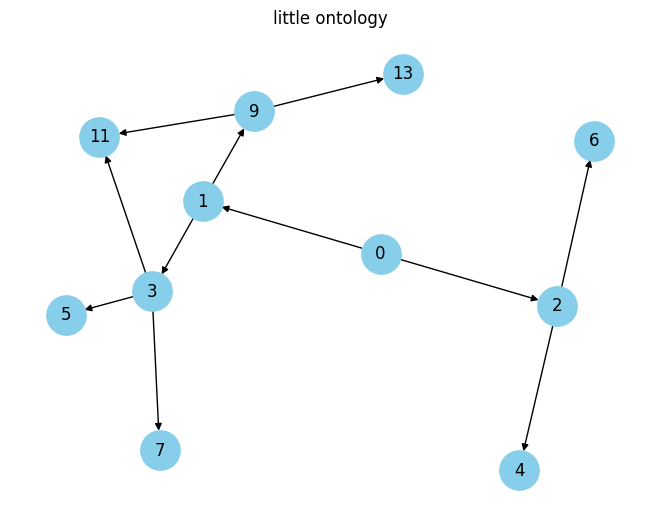

Retrieving ancestors of each leaf: 100%|██████████| 4/4 [00:00<00:00, 74898.29it/s]


In [11]:
LO_edge_index = torch.tensor([[0,0,1,1,2,2,3,3,9, 9, 3],  # Departure nodes
                              [1,2,3,9,4,6,5,7,11,13, 11]], # Arrival nodes
                              dtype=torch.long)
LO_edges = LO_edge_index.t().tolist()

# Initialize the ontology with the specified edges and display the graph
LO = init_ontology(LO_edges, display_output=True, output_name = "little ontology")
LO_leaves_ancestors = get_leaves_and_ancestors(LO_nx)


In [12]:
type(LO.graph)

networkx.classes.digraph.DiGraph

# Loading models

In [ ]:
epochs = 15

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device: '{device}'")

pwc.map_to_GO        = idx_to_go
pwc.mapped_alt_tails = None
pwc.device           = device

ComplEx(82249, num_relations=1162017, hidden_channels=1)


In [ ]:
! pip install torch-sparse
! apt-get install libsparsehash-dev

import torch
import os
import sys
sys.path.append('/home/ebutz/ESL2024/code/utils' )
import optuna
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.sampler import NegativeSampling
import torch_geometric.transforms as T
import pickle
import os
import sys
import torch
import torch.optim as optim
import torch_geometric
from torch_geometric.nn import ComplEx
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from nxontology.imports import from_file
import wandb
from play_with_complex import *
from data_utils import *
from train_utils import *
from model_utils import *
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
from torchmetrics.retrieval import RetrievalMRR, RetrievalHitRate
import play_with_complex as pwc

def evaluate(config, loader, model, criterion, compute_all_metrics=False, loader_type='validation', stopper_metric=False):
    """
    Evaluate the model on a given data loader.

    Parameters
    ----------
    config : object
        An object containing the configuration parameters for the model.
    loader : DataLoader
        The data loader to evaluate the model on.
    model : Model
        The model to evaluate.
    criterion : callable
        The loss function to use for evaluation.
    compute_all_metrics : bool, optional
        Whether to compute all metrics or partially. Default is False.
    loader_type : str, optional
        The type of the loader ('validation' or 'test'). Default is 'validation'.
    stopper_metric : str or bool, optional
        The metric that dictates when to stop training. If False, only the loss is computed. Default is False.

    Returns
    -------
    tuple
        A tuple of the evaluation metric and the loss, depending on the value of `stopper_metric`.
        If compute_all_metrics is True, the function logs all metrics to W&B.
    """

    print("Evaluation...")
    model.eval()
    num_neg_samples = loader.neg_sampling.amount
    with torch.no_grad():
        if stopper_metric or compute_all_metrics:
            ground_truths = torch.tensor([], device='cpu')
            preds = torch.tensor([], device='cpu')
            indexes = torch.tensor([], device='cpu')
            total_loss, total_examples = 0, 0
            index_end = loader.batch_size

        for sampled_data in loader:
            sampled_data = sampled_data.to(device)

            batch_size = len(sampled_data[config.labels['tail']].dst_pos_index)
            pred = model(sampled_data, config)
            pos_samples = torch.ones(batch_size, device=device)
            neg_samples = torch.zeros(num_neg_samples*batch_size, device=device)
            ground_truth = torch.cat((pos_samples, neg_samples))

            if stopper_metric or compute_all_metrics: # Store preds and truths for all batches, and compute indices to calc metrics
                index_pos = torch.arange(end=index_end, start=index_end-batch_size) # index for predictions with pos. ground_truth
                index_neg = torch.arange(end=index_end, start=index_end-batch_size).repeat_interleave(num_neg_samples)
                index = torch.cat((index_pos, index_neg))
                indexes = torch.cat((indexes, index.to('cpu')))
                preds = torch.cat((preds, pred.to('cpu')))
                ground_truths = torch.cat((ground_truths, ground_truth.to('cpu')))
                index_end += batch_size

            # eval_loss = criterion(pred, ground_truth, gamma=config.gamma, alpha=config.alpha)

            # if not stopper_metric: # Just logging loss
            #     wandb.log({"running_val_loss": eval_loss})
            #     break
            # else: !
            # total_loss += float(eval_loss) * pred.numel()
            # total_examples += pred.numel()
            # eval_loss = total_loss / total_examples

            # if stopper_metric and not compute_all_metrics:
            #     if index_end >= 2048: # Compute approx. intermediate metric on a few datapoints to speed up hyperopt process
            #         break


        model.train()

        if stopper_metric and not compute_all_metrics: # Compute only the metric that dictates stopping
            indexes = indexes.long()

            # # Log heatmap between prediction and ground truth. Useful for visualization / debugging. overhead 0.2s per epoch for a single sample.
            # heatmap = heatmaps(preds, ground_truths, indexes)
            # wandb.log({f"heatmap": wandb.Image(heatmap)})
            # heatmap.close() # Free up memory

            match stopper_metric:
                # case "val_loss":
                #     eval_loss = total_loss / total_examples
                #     return eval_loss

                case "mrr":
                    mrr = RetrievalMRR().to(device)
                    return mrr(preds, ground_truths, indexes=indexes), eval_loss

                case "hit_at_10":
                    hit_at_10 = RetrievalHitRate(top_k=10).to(device)
                    return hit_at_10(preds, ground_truths, indexes=indexes), eval_loss

                case "hit_at_5":
                    hit_at_5 = RetrievalHitRate(top_k=5).to(device)
                    return hit_at_5(preds, ground_truths, indexes=indexes), eval_loss

                case "hit_at_3":
                    hit_at_3 = RetrievalHitRate(top_k=3).to(device)
                    return hit_at_3(preds, ground_truths, indexes=indexes), eval_loss

                case "hit_at_1":
                    hit_at_1 = RetrievalHitRate(top_k=1).to(device)
                    return hit_at_1(preds, ground_truths, indexes=indexes), eval_loss

                case _:
                    raise ValueError(f"Unrecognized stopper metric: '{stopper_metric}'")

        if compute_all_metrics: # Compute all metrics at the end of training
            indexes = indexes.long()
            mrr = RetrievalMRR().to(device)
            hit_at_10 = RetrievalHitRate(top_k=10).to(device)
            hit_at_5 = RetrievalHitRate(top_k=5).to(device)
            hit_at_3 = RetrievalHitRate(top_k=3).to(device)
            hit_at_1 = RetrievalHitRate(top_k=1).to(device)

            mrr = mrr(preds, ground_truths, indexes=indexes)
            hit_at_10 = hit_at_10(preds, ground_truths, indexes=indexes)
            hit_at_5 = hit_at_5(preds, ground_truths, indexes=indexes)
            hit_at_3 = hit_at_3(preds, ground_truths, indexes=indexes)
            hit_at_1 = hit_at_1(preds, ground_truths, indexes=indexes)

            wandb.log({
                f"{loader_type}MRR": mrr, f"{loader_type}hit_at_10": hit_at_10, f"{loader_type}hit_at_5": hit_at_5, f"{loader_type}hit_at_3": hit_at_3, f"{loader_type}hit_at_1": hit_at_1
            })

            eval_loss = 1

    return mrr, eval_loss

def train(config, train_loader, val_loader, model, criterion, loss_name, optimizer, early_stopper, labels_type = 'usual', eval_period = 0, xp_name ="not indicated"):
    print("LOSS :", criterion)
    print("XP name :", xp_name)
    for epoch in range(config.epochs):
        total_loss = total_examples = 0

        for sampled_data in tqdm(train_loader, desc="Training"):

            sampled_data = sampled_data.to(device)
            pred = model(sampled_data, config)
            pos_samples  = torch.ones(len(sampled_data[config.labels['tail']].dst_pos_index), device=device)
            neg_samples  = torch.zeros(len(sampled_data[config.labels['tail']].dst_neg_index.view(-1)), device=device) # As many zeroes as there are negative samples * batch_size
            ground_truth = torch.cat((pos_samples, neg_samples))

            false_tails = sampled_data[config.labels['tail']].dst_neg_index.view(-1)
            true_tails = sampled_data['go']['dst_pos_index']
            true_tails = torch.repeat_interleave(true_tails,int(false_tails.size()[0]/true_tails.size()[0]))


            if labels_type == 'linsim':

                lin_neg_samples = pwc.lin_sims_for_batch(true_tails, false_tails)

                pos_samples = pos_samples.to(device)
                lin_neg_samples = lin_neg_samples.to(device)

                ground_truth = torch.cat((pos_samples, lin_neg_samples))

            if labels_type == 'rand_linsim':

                linsims = pwc.lin_sims_for_batch(true_tails, false_tails)
                lin_neg_samples = pwc.shuffle_tensor(linsims)
                lin_neg_samples.to(device)
                pos_samples.to(device)

                ground_truth = torch.cat((pos_samples, lin_neg_samples))
                ground_truth.to(device)

            if labels_type == 'gaussian_noise':
                # Add gaussian noise to pos_samples to simulate noisy labels. Added noise must be negative and not exceed 1.
                ground_truth += torch.normal(mean=0, std=1, size=(len(ground_truth),), device=device).to(device)
                # apply sigmoid
                ground_truth = torch.sigmoid(ground_truth).to(device)

            if labels_type == 'usual':
                ground_truth = torch.sigmoid(ground_truth).to(device)

            if loss_name == "MSE":
                loss = criterion(pred, ground_truth)
            elif loss_name == "sigmoid focal":
                loss = criterion(pred, ground_truth, gamma=config.gamma, alpha=config.alpha)
            else :
                print("Unrecognized loss !")

            wandb.log({"loss": loss})

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_loss += float(loss) * pred.numel()
            total_examples += pred.numel()

        score, val_loss = evaluate(config, val_loader, model, criterion, stopper_metric=config.stopper_metric, compute_all_metrics= True)
        wandb.log({"val_loss": val_loss, f"{config.stopper_metric}": score})

        train_loss = total_loss / total_examples
        print(f"Epoch: {epoch:03d}, Avg. Loss: {train_loss:.10f}")




        # early_stopper(score)
        # if early_stopper.early_stop:
        #     print("Early stopping triggered at epoch", epoch)
        #     break

    print("Training done.")

for i in range(1):
      # Which labels should be used ?
      # Choices are : 'usual', 'rand_linsim', linsim', 'gaussian_noise', 'usual'.
      labels_type = 'usual'
      loss_name = 'MSE'

      # How many epochs between 2 time-consuming evaluations ?
      eval_period = 1

      # Wandb
      xp_name = 'GNN Baseline VS LinSim VS Noise With MSE'
      run_name = f'{labels_type} labels and {loss_name}'
      print(xp_name,':',run_name)

      run = wandb.init(project=xp_name, name = run_name)
      config = wandb.config
      config.labels_type = labels_type
      config.val_ratio=0.1
      config.homogeneous=False
      config.scorelist_size=1000
      config.split_ratio=0.8
      config.val_ratio=0.1
      config.test_ratio=0.1
      config.num_neighbors=[70,55,13,89,85]
      config.batch_size=1024
      config.train_neg_sampling_ratio=224
      config.epochs=epochs
      config.disjoint_train_ratio=0.6
      config.lr=0.0015308253347932983
      config.stopper_metric= 'hit_at_10'
      config.stopper_direction="maximize"
      config.stopper_patience=5
      config.stopper_frequency=1
      config.stopper_relative_delta=0.05
      config.gamma=1.3
      config.alpha=0.42680473078813763
      config.gnn_layer='ResGatedGraphConv'
      config.dropout=0.1
      config.norm='DiffGroupNorm'
      config.aggregation = 'min'
      config.hidden_channels=115
      config.num_layers=3
      config.attention_heads=4
      config.homogeneous = False
      config.labels = {'head' : 'genes', 'relation' : 'gene_ontology', 'tail' : 'go'}

      train_data, val_data, test_data = split_data(data, config)
      train_loader, val_loader, test_loader = build_dataloaders(train_data, val_data, test_data, config)


      gnn_layers = get_gnn_layers(config)
      norm_layers = get_norm_layers(config, len(data.node_types))

      model = Model(config, data, norm_layers, gnn_layers).to(device)

      criterion = torch.nn.MSELoss()

      optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

      early_stopper = EarlyStopper(frequency=config.stopper_frequency, patience=config.stopper_patience,
                              direction=config.stopper_direction, relative_delta=config.stopper_relative_delta)

      train(config = config, train_loader = train_loader, val_loader =  val_loader, model = model,
            criterion = criterion, optimizer = optimizer, early_stopper = None, eval_period = 0, xp_name=run_name,
            loss_name=loss_name, labels_type=labels_type)


      # evaluate(config,  val_loader, model, criterion, compute_all_metrics=False, loader_type='validation', stopper_metric='hit_at_10')
      # evaluate(config, test_loader, model, criterion, compute_all_metrics=False, loader_type='test'      , stopper_metric='hit_at_10')


      wandb.finish()

In [ ]:
for i in range(1):
      # Which labels should be used ?
      # Choices are : 'usual', 'rand_linsim', linsim', 'gaussian_noise', 'usual'.
      labels_type = 'usual'
      loss_name = 'MSE'

      # How many epochs between 2 time-consuming evaluations ?
      eval_period = 1

      # Wandb
      xp_name = 'GNN Baseline VS LinSim VS Noise With MSE'
      run_name = f'{labels_type} labels and {loss_name}'
      print(xp_name,':',run_name)

      run = wandb.init(project=xp_name, name = run_name)
      config = wandb.config
      config.labels_type = labels_type
      config.val_ratio=0.1
      config.homogeneous=False
      config.scorelist_size=1000
      config.split_ratio=0.8
      config.val_ratio=0.1
      config.test_ratio=0.1
      config.num_neighbors=[70,55,13,89,85]
      config.batch_size=1024
      config.train_neg_sampling_ratio=224
      config.epochs=epochs
      config.disjoint_train_ratio=0.6
      config.lr=0.0015308253347932983
      config.stopper_metric= 'hit_at_10'
      config.stopper_direction="maximize"
      config.stopper_patience=5
      config.stopper_frequency=1
      config.stopper_relative_delta=0.05
      config.gamma=1.3
      config.alpha=0.42680473078813763
      config.gnn_layer='ResGatedGraphConv'
      config.dropout=0.1
      config.norm='DiffGroupNorm'
      config.aggregation = 'min'
      config.hidden_channels=115
      config.num_layers=3
      config.attention_heads=4
      config.homogeneous = False
      config.labels = {'head' : 'genes', 'relation' : 'gene_ontology', 'tail' : 'go'}

      train_data, val_data, test_data = split_data(data, config)
      train_loader, val_loader, test_loader = build_dataloaders(train_data, val_data, test_data, config)


      gnn_layers = get_gnn_layers(config)
      norm_layers = get_norm_layers(config, len(data.node_types))

      model = Model(config, data, norm_layers, gnn_layers).to(device)

      criterion = torch.nn.MSELoss()

      optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

      early_stopper = EarlyStopper(frequency=config.stopper_frequency, patience=config.stopper_patience,
                              direction=config.stopper_direction, relative_delta=config.stopper_relative_delta)

      train(config = config, train_loader = train_loader, val_loader =  val_loader, model = model,
            criterion = criterion, optimizer = optimizer, early_stopper = None, eval_period = 0, xp_name=run_name,
            loss_name=loss_name, labels_type=labels_type)


      # evaluate(config,  val_loader, model, criterion, compute_all_metrics=False, loader_type='validation', stopper_metric='hit_at_10')
      # evaluate(config, test_loader, model, criterion, compute_all_metrics=False, loader_type='test'      , stopper_metric='hit_at_10')


      wandb.finish()

# Retrieving leaf-ancestor similarity 

In [ ]:
def get_distance(graph, node1, node2):
    if node1 == node2:
        return int(0)
    else :
        return len(nx.bidirectional_shortest_path(graph, source = node1, target = node2))
    
def get_similarity(ontology, node1, node2):
    return ontology.similarity(node1,node2).lin

print(get_distance(GO_nx,go_to_idx['GO:0006281'],  # DNA Repair
                         go_to_idx['GO:0006974'])) # DNA Damage response

print(get_similarity(GO_ontology, go_to_idx['GO:0006281'],  # DNA Repair
                                  go_to_idx['GO:0006974'])) # DNA Damage response

2
0.9980608679276305


In [ ]:
distances_and_similarities = pd.DataFrame(columns=['leaf','ancestor', 'distance', 'similarity', 'model_score'])

leaves, ancestors =  [], []

for _, (leaf, leaf_ancestors) in enumerate(GO_leaves_ancestors.items()):
     for leaf_ancestor in leaf_ancestors:
        leaves.append(leaf)
        ancestors.append(leaf_ancestor)

distances_and_similarities['leaf']= leaves
distances_and_similarities['ancestor']= ancestors

display(distances_and_similarities[0:10000])
distances_and_similarities = distances_and_similarities[]
tqdm.pandas(desc='Calculating leaves-ancestors distances')
distances_and_similarities['distance'] = distances_and_similarities.progress_apply(lambda row: get_distance(GO_nx, row['leaf'], row['ancestor']), axis=1)

tqdm.pandas(desc='Calculating leaves_ancestos similarities')
distances_and_similarities['similarity'] = distances_and_similarities.progress_apply(lambda row: get_similarity(GO_ontology, row['leaf'], row['ancestor']), axis=1)





Calculating leaves_ancestos similarities:   0%|          | 824/324799 [00:46<5:05:43, 17.66it/s]


KeyboardInterrupt: 

In [ ]:
# Here we create a model which perfectly predicts similarity.
def perfect_model(leaf, ancestor):
    return 

In [ ]:
distances_and_similarities = distances_and_similarities[distances_and_similarities.distance != 0]
distances_and_similarities

,leaf,ancestor,distance,similarity,model_score
0,18227,33891,3,NaN,NaN
1,18227,8963,6,NaN,NaN
2,18227,40932,2,NaN,NaN
3,18227,3624,4,NaN,NaN
4,18227,16173,3,NaN,NaN
...,...,...,...,...,...
324794,5297,23645,2,NaN,NaN
324795,5297,31976,3,NaN,NaN
324796,5297,10992,4,NaN,NaN
324797,5297,26358,5,NaN,NaN


# Comparing ontologies comprehension of the trained models

In [ ]:
isa_id = 1

heads     = torch.Tensor(distances_and_similarities['leaf'].values).to(torch.long)
relations = torch.Tensor([isa_id]*heads.shape[0]).to(torch.long)
tails     = torch.Tensor(distances_and_similarities['ancestor'].values).to(torch.long)
print(heads, relations, tails)

tensor([18227, 18227, 18227,  ...,  5297,  5297,  5297]) tensor([1, 1, 1,  ..., 1, 1, 1]) tensor([33891,  8963, 40932,  ..., 10992, 26358, 15867])


In [ ]:
scores = to_complex(heads, relations, tails)

distances_and_similarities['model_score'] = scores.tolist()
display(distances_and_similarities)

,leaf,ancestor,distance,similarity,model_score
0,18227,33891,3,NaN,-0.000150
1,18227,8963,6,NaN,-0.000289
2,18227,40932,2,NaN,-0.000210
3,18227,3624,4,NaN,-0.000178
4,18227,16173,3,NaN,0.000150
...,...,...,...,...,...
324794,5297,23645,2,NaN,0.000401
324795,5297,31976,3,NaN,0.000398
324796,5297,10992,4,NaN,0.000306
324797,5297,26358,5,NaN,0.000241


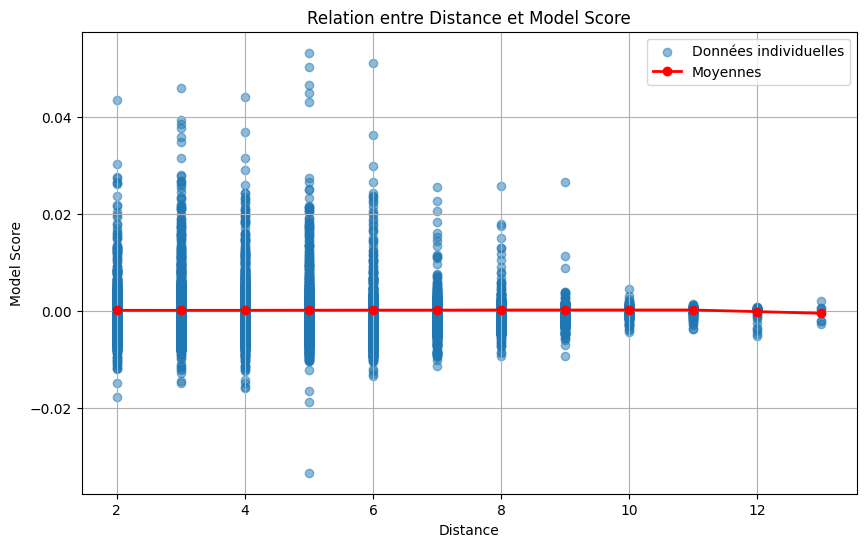

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Supposons que le DataFrame est déjà chargé dans distances_and_similarities

# Calculer la moyenne de model_score pour chaque valeur de distance
mean_scores = distances_and_similarities.groupby('distance')['model_score'].mean().reset_index()

# Scatter plot initial
plt.figure(figsize=(10, 6))
plt.scatter(distances_and_similarities['distance'], distances_and_similarities['model_score'], alpha=0.5, label='Données individuelles')

# Ajouter les valeurs moyennes
plt.plot(mean_scores['distance'], mean_scores['model_score'], color='red', marker='o', linestyle='-', linewidth=2, markersize=6, label='Moyennes')

# Calculer la droite de tendance
slope, intercept = np.polyfit(distances_and_similarities['distance'], distances_and_similarities['model_score'], 1)
trendline = slope * distances_and_similarities['distance'] + intercept

# # Ajouter la droite de tendance
# plt.plot(distances_and_similarities['distance'], trendline, color='blue', linestyle='--', linewidth=2, label='Droite de tendance')

# Titre et labels
plt.title('Relation entre Distance et Model Score')
plt.xlabel('Distance')
plt.ylabel('Model Score')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
correlation, p_value = pearsonr(distances_and_similarities['distance'], distances_and_similarities['model_score'])
print(f"Correlation de Pearson: {correlation}")
print(f"P-value: {p_value}")

Correlation de Pearson: 0.01698014124492961
P-value: 1.9059908541861115e-20
